<a href="https://colab.research.google.com/github/Archi2903/AI-in-Engenery/blob/main/CNN_project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\

## Make TEM data
1. Original TEM signal
2. Noisy TEM signal

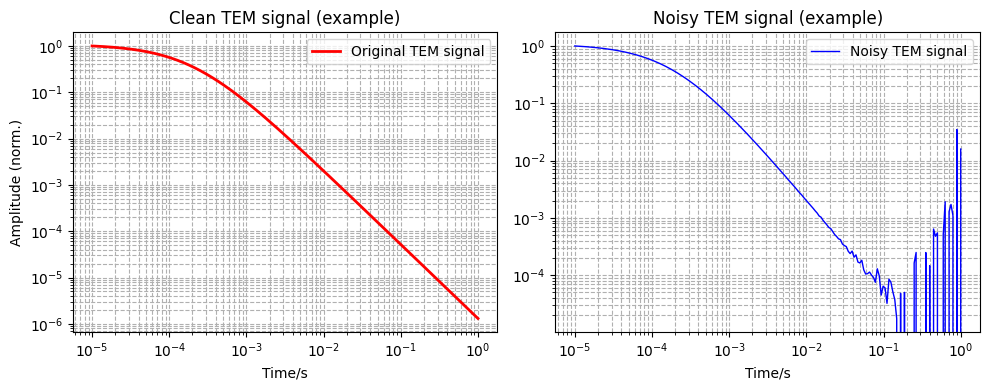

In [157]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Генерация одной опорной кривой TEM сигнала
def generate_reference_tem_signal(t, tau=2e-4, n=1.6):
    signal = 1 / (t + tau)**n
    return signal / np.max(signal)  # нормализация

# 2. Генератор датасета из 200 кривых на основе одной референсной, с шумом
def generate_dataset_from_reference(n_samples=200, n_points=200, sigma_min=1e-5, sigma_max=5e-2):
    t = np.logspace(-5, 0, n_points)
    reference_signal = generate_reference_tem_signal(t)
    clean_signals = np.tile(reference_signal, (n_samples, 1))  # все одинаковые
    noisy_signals = []

    # Экспоненциальный рост шума по времени
    normalized_t = (t - t[0]) / (t[-1] - t[0])
    sigma_t = sigma_min * np.exp(normalized_t * np.log(sigma_max / sigma_min))

    for _ in range(n_samples):
        noise = np.random.normal(0, sigma_t)
        noisy = reference_signal + noise
        noisy_signals.append(noisy)

    return t, clean_signals, np.array(noisy_signals)

# Генерация
t, clean_dataset, noisy_dataset = generate_dataset_from_reference()

# Пример: визуализация первой чистой и зашумлённой кривой
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.loglog(t, clean_dataset[0], color='red', linewidth=2, label='Original TEM signal')
plt.xlabel("Time/s")
plt.ylabel("Amplitude (norm.)")
plt.title("Clean TEM signal (example)")
plt.grid(True, which='both', ls='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.loglog(t, noisy_dataset[0], color='blue', linewidth=1, label='Noisy TEM signal')
plt.xlabel("Time/s")
plt.title("Noisy TEM signal (example)")
plt.grid(True, which='both', ls='--')
plt.legend()

plt.tight_layout()
plt.show()


## Make TEM datagenerator
200 samples
plot 5 random curves

In [159]:
def generate_dataset_varied_clean(n_samples=200, n_points=200, tau_range=(1e-4, 3e-4), n_range=(1.4, 1.7)):
    """
    Генерация чистых TEM сигналов с небольшими вариациями параметров.

    Возвращает:
        t — логарифмически распределённое время
        clean_signals — массив [n_samples, n_points]
    """
    t = np.logspace(-5, 0, n_points)
    clean_signals = []

    for _ in range(n_samples):
        tau = np.random.uniform(*tau_range)
        n_val = np.random.uniform(*n_range)
        signal = 1 / (t + tau)**n_val
        signal /= np.max(signal)
        clean_signals.append(signal)

    return t, np.array(clean_signals)


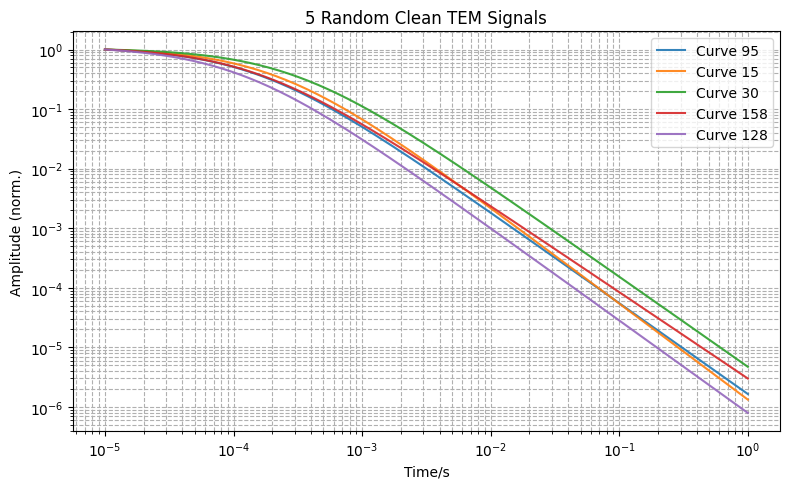

In [160]:
# Генерация набора с лёгкими вариациями
t, varied_clean_signals = generate_dataset_varied_clean()

# Визуализация 5 случайных
plot_random_clean_signals(t, varied_clean_signals, n=5, seed=42)


In [162]:
def prepare_tem_dataset_for_training(n_samples=200, n_points=200,
                                     tau_range=(1e-4, 3e-4), n_range=(1.4, 1.7),
                                     sigma_min=1e-5, sigma_max=5e-2):
    """
    Генерирует синтетический TEM датасет с шумом и чистыми сигналами,
    готовый для обучения моделей LSTM и CNN.

    Возвращает:
        X: вход (шумный сигнал), shape (samples, time_points, 1)
        y: выход (чистый сигнал), shape (samples, time_points, 1)
        t: временная шкала
    """
    t = np.logspace(-5, 0, n_points)
    X, y = [], []

    for _ in range(n_samples):
        tau = np.random.uniform(*tau_range)
        n_val = np.random.uniform(*n_range)
        clean = 1 / (t + tau)**n_val
        clean /= np.max(clean)

        # Шум усиливается на позднем времени
        normalized_t = (t - t[0]) / (t[-1] - t[0])
        sigma_t = sigma_min * np.exp(normalized_t * np.log(sigma_max / sigma_min))
        noise = np.random.normal(0, sigma_t)
        noisy = clean + noise

        X.append(noisy)
        y.append(clean)

    X = np.expand_dims(np.array(X), axis=-1)  # shape: (samples, time_points, 1)
    y = np.expand_dims(np.array(y), axis=-1)
    return X, y, t


In [163]:
X, y, t = prepare_tem_dataset_for_training(n_samples=200, n_points=200)


In [164]:
np.save('X_noisy.npy', X)
np.save('y_clean.npy', y)
np.save('t_timescale.npy', t)


In [165]:
from sklearn.model_selection import train_test_split

# X, y — данные, ранее сгенерированные функцией prepare_tem_dataset_for_training

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)


## Dataset split 80/20

In [166]:
print("Train set:", X_train.shape, y_train.shape)
print("Val set:  ", X_val.shape, y_val.shape)


Train set: (160, 200, 1) (160, 200, 1)
Val set:   (40, 200, 1) (40, 200, 1)


## CNN Model

In [174]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# X, y — данные, ранее сгенерированные функцией prepare_tem_dataset_for_training
X, y, t = prepare_tem_dataset_for_training(n_samples=200, n_points=200)

# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# CNN архитектура для денойзинга
class CNNDenoiser(nn.Module):
    def __init__(self):
        super(CNNDenoiser, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 1, kernel_size=5, padding=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Настройка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Инициализация модели, оптимизатора и функции потерь
model = CNNDenoiser().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Преобразование данных в PyTorch-тензоры
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device) # Corrected: Y_train to y_train
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
Y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)   # Corrected: Y_val to y_val

# Параметры обучения
num_epochs = 100
batch_size = 32

# Обучение
for epoch in range(1, num_epochs + 1):
    model.train()
    permutation = torch.randperm(X_train_t.size(0))
    epoch_loss = 0.0

    for i in range(0, X_train_t.size(0), batch_size):
        idx = permutation[i:i + batch_size]
        batch_x = X_train_t[idx].permute(0, 2, 1)  # (B, 1, T)
        batch_y = Y_train_t[idx].permute(0, 2, 1)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)

    epoch_loss /= X_train_t.size(0)

    # Validation
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_output = model(X_val_t.permute(0, 2, 1))
            val_loss = criterion(val_output, Y_val_t.permute(0, 2, 1)).item()
        print(f"Epoch {epoch:03d} | Train MSE: {epoch_loss:.6f} | Val MSE: {val_loss:.6f}")

Epoch 010 | Train MSE: 0.000635 | Val MSE: 0.000440
Epoch 020 | Train MSE: 0.000021 | Val MSE: 0.000019
Epoch 030 | Train MSE: 0.000009 | Val MSE: 0.000009
Epoch 040 | Train MSE: 0.000005 | Val MSE: 0.000005
Epoch 050 | Train MSE: 0.000004 | Val MSE: 0.000003
Epoch 060 | Train MSE: 0.000003 | Val MSE: 0.000002
Epoch 070 | Train MSE: 0.000002 | Val MSE: 0.000002
Epoch 080 | Train MSE: 0.000002 | Val MSE: 0.000002
Epoch 090 | Train MSE: 0.000002 | Val MSE: 0.000002
Epoch 100 | Train MSE: 0.000002 | Val MSE: 0.000001


Эпоха  10, MSE (train) = 0.004978, MSE (val) = 0.004995
Эпоха  20, MSE (train) = 0.002382, MSE (val) = 0.002609
Эпоха  30, MSE (train) = 0.001829, MSE (val) = 0.002028
Эпоха  40, MSE (train) = 0.001259, MSE (val) = 0.001365
Эпоха  50, MSE (train) = 0.001153, MSE (val) = 0.001255
Эпоха  60, MSE (train) = 0.001111, MSE (val) = 0.001214
Эпоха  70, MSE (train) = 0.001095, MSE (val) = 0.001193
Эпоха  80, MSE (train) = 0.001079, MSE (val) = 0.001183
Эпоха  90, MSE (train) = 0.001070, MSE (val) = 0.001169
Эпоха 100, MSE (train) = 0.001056, MSE (val) = 0.001187

Параметры модели по слоям:
conv1.weight                        : 80 параметров
conv1.bias                          : 16 параметров
conv2.weight                        : 1280 параметров
conv2.bias                          : 16 параметров
conv3.weight                        : 80 параметров
conv3.bias                          : 1 параметров

Общее число обучаемых параметров: 1473



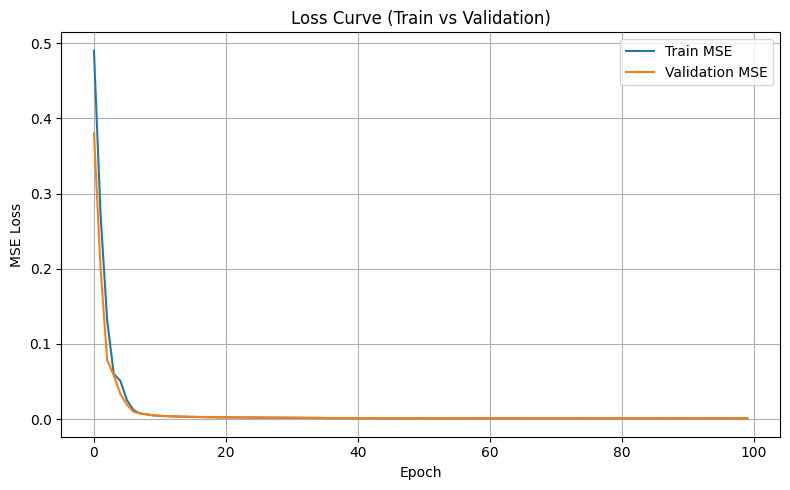

In [176]:
import torch.nn as nn
import torch # Import torch
import numpy as np # Import numpy for np.arange
import matplotlib.pyplot as plt

# Определяем архитектуру 1D CNN для денойзинга
class CNNDenoiser(nn.Module):
    def __init__(self):
        super(CNNDenoiser, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=5, padding=2)
        self.act = nn.ReLU()
    def forward(self, x):
        # x имеет форму (batch, 1, N)
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.conv3(x)  # на выходе активация не применяется (линейный выход)
        return x

# Создаем экземпляр модели и определяем оптимизатор и функцию потерь
device = torch.device('cpu')
model_cnn = CNNDenoiser().to(device)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Преобразуем данные в тензоры PyTorch, явно указывая тип float32
# X_train and Y_train are (num_samples, N) from the data generation in cell rxKKQJas6EUe
X_train_t = torch.from_numpy(X_train).float().to(device)
Y_train_t = torch.from_numpy(Y_train).float().to(device)

train_losses = []
val_losses = []

# Обучение модели CNN
num_epochs = 100
batch_size = 50
for epoch in range(1, num_epochs+1):
    # Перемешиваем обучающие данные в начале эпохи
    permutation = torch.randperm(X_train_t.size(0))
    epoch_loss = 0.0
    model_cnn.train()
    for i in range(0, X_train_t.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        # Reshape (batch, N) to (batch, 1, N) for Conv1d input
        batch_x = X_train_t[indices].unsqueeze(1)
        batch_y = Y_train_t[indices].unsqueeze(1)

        optimizer.zero_grad()
        output = model_cnn(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)

    epoch_loss /= X_train_t.size(0) # Average loss over all samples in the epoch
    train_losses.append(epoch_loss) # Append the correct epoch loss

    # Validation step to compute val_loss
    # X_test and Y_test are (num_samples, N)
    X_test_t = torch.from_numpy(X_test).float().to(device) # Ensure test data is also float32
    Y_test_t = torch.from_numpy(Y_test).float().to(device)

    model_cnn.eval()
    with torch.no_grad():
        # Reshape (batch, N) to (batch, 1, N) for Conv1d input
        val_output = model_cnn(X_test_t.unsqueeze(1))
        val_loss = criterion(val_output, Y_test_t.unsqueeze(1)).item()
        val_losses.append(val_loss) # Append validation loss
    model_cnn.train() # Set back to train mode

    # Каждые 10 эпох выводим средний MSE по обучающим данным
    if epoch % 10 == 0:
        print(f"Эпоха {epoch:3d}, MSE (train) = {epoch_loss:.6f}, MSE (val) = {val_loss:.6f}")

# Подсчет количества параметров
def count_parameters(model):
    print("\nПараметры модели по слоям:")
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name:35s} : {param.numel()} параметров")
            total_params += param.numel()
    print(f"\nОбщее число обучаемых параметров: {total_params}\n")

count_parameters(model_cnn)


plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Validation MSE')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Curve (Train vs Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [178]:
import torch
import numpy as np

# Убедимся, что модель в режиме оценки
model_cnn.eval()

# Преобразуем тестовые данные в тензоры
X_test_t = torch.from_numpy(X_test).float().to(device)  # (samples, N)
Y_test_t = torch.from_numpy(Y_test).float().to(device)  # (samples, N)

# Применяем модель CNN
with torch.no_grad():
    # Добавим размер канала: (batch, 1, N)
    denoised_cnn = model_cnn(X_test_t.unsqueeze(1))  # (batch, 1, N)
    denoised_cnn_np = denoised_cnn.cpu().numpy().squeeze()  # → (batch, N)

# Метрики
def compute_snr_db(clean, denoised):
    noise = clean - denoised
    signal_power = np.mean(clean**2, axis=1)
    noise_power = np.mean(noise**2, axis=1)
    snr_values = 10 * np.log10(signal_power / (noise_power + 1e-12))
    return snr_values.mean()

def compute_rmse(clean, denoised):
    return np.mean(np.sqrt(np.mean((clean - denoised)**2, axis=1)))

# Вычисление на тесте
snr_cnn = compute_snr_db(Y_test, denoised_cnn_np)
rmse_cnn = compute_rmse(Y_test, denoised_cnn_np)

print(f"SNR (CNN)  = {snr_cnn:.2f} дБ")
print(f"RMSE (CNN) = {rmse_cnn:.4f}")


SNR (CNN)  = 27.09 дБ
RMSE (CNN) = 0.0336


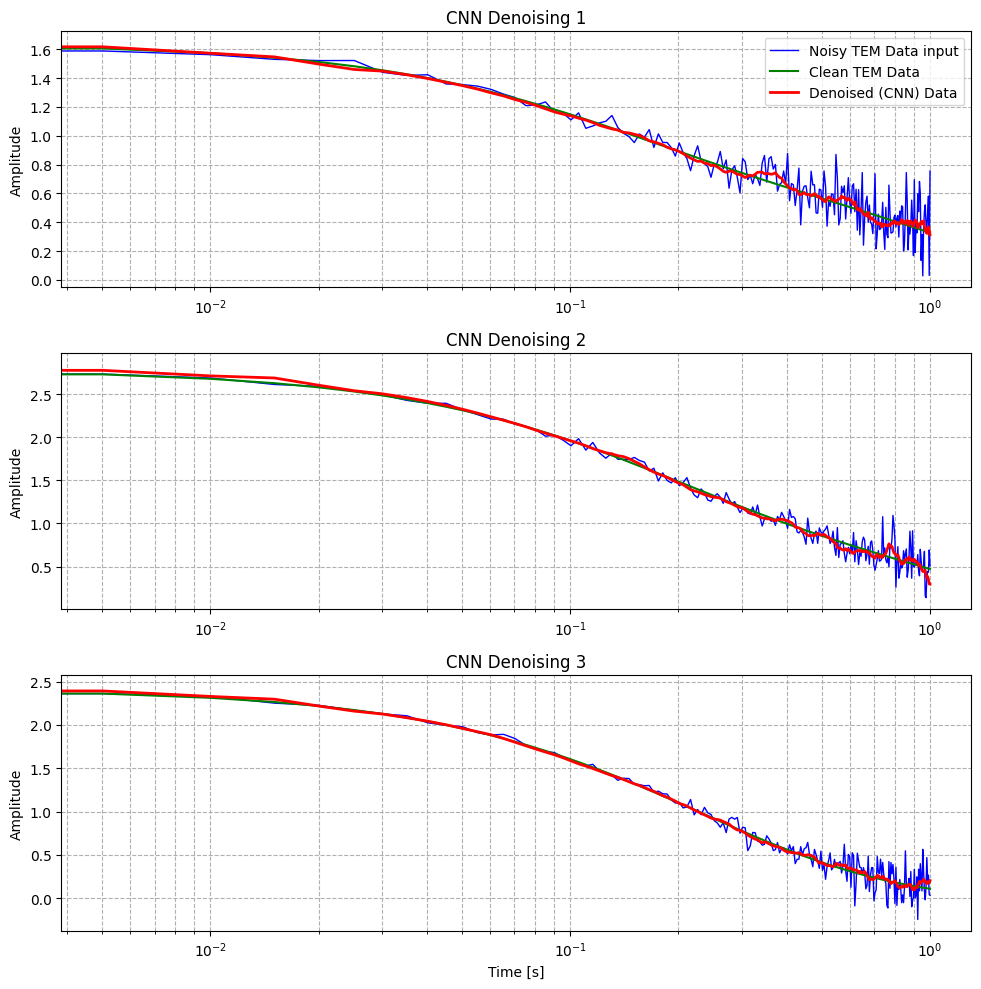

In [192]:
import matplotlib.pyplot as plt

# Визуализация: сравнение шумного, чистого и отфильтрованного сигнала
n_examples = 3  # Сколько примеров показать
indices = np.random.choice(len(X_test), n_examples, replace=False)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(indices):
    plt.subplot(n_examples, 1, i + 1)
    plt.plot(t, X_test[idx], label='Noisy TEM Data input', color='blue', linewidth=1)
    plt.plot(t, Y_test[idx], label='Clean TEM Data', color='green', linestyle='-', linewidth=1.5)
    plt.plot(t, denoised_cnn_np[idx], label='Denoised (CNN) Data', color='red', linewidth=2)
    plt.xscale('log')
    plt.ylabel("Amplitude")
    if i == 0:
        plt.legend(loc='upper right')
    if i == n_examples - 1:
        plt.xlabel("Time [s]")
    plt.title(f"CNN Denoising {i+1}")
    plt.grid(True, which='both', ls='--')

plt.tight_layout()
plt.show()


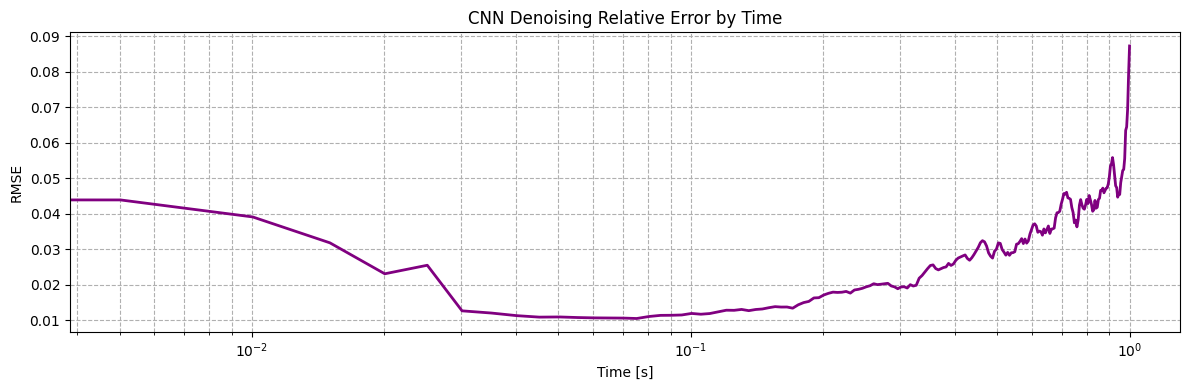

In [196]:
# График средней ошибки (RMSE) по времени
import numpy as np
import matplotlib.pyplot as plt

# Ошибка по каждому временному отсчёту: (samples, N) → среднее по осям 0
mse_per_timestep = np.mean((denoised_cnn_np - Y_test)**2, axis=0)
rmse_per_timestep = np.sqrt(mse_per_timestep)

# Визуализация
plt.figure(figsize=(12, 4))
plt.plot(t, rmse_per_timestep, color='purple', linewidth=2)
plt.xscale('log')
plt.xlabel("Time [s]")
plt.ylabel("RMSE")
plt.title("CNN Denoising Relative Error by Time")
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

In [3]:
import math

# Применяем обученные модели ко всему тестовому набору
model_cnn.eval()
model_lstm.eval()
X_test_t = torch.from_numpy(X_test).float().to(device) # Ensure float32 and move to device
Y_test_t = torch.from_numpy(Y_test).float().to(device) # Ensure float32 and move to device

with torch.no_grad():
    # CNN expects (batch, 1, N), output will be (batch, 1, N)
    denoised_cnn = model_cnn(X_test_t.unsqueeze(1)).cpu().numpy().squeeze()
    # LSTM expects (batch, N, 1), output will be (batch, N, 1)
    denoised_lstm = model_lstm(X_test_t.unsqueeze(-1)).cpu().numpy().squeeze()

# Функции для вычисления SNR (дБ) и RMSE
def compute_snr_db(clean, denoised):
    # clean и denoised - numpy-массивы размером (количество_сигналов, N)
    noise = clean - denoised
    # мощность сигнала и шума по каждому сигналу:
    signal_power = np.mean(clean**2, axis=1)
    noise_power = np.mean(noise**2, axis=1)
    # SNR для каждого сигнала, затем усредняем и переводим в дБ
    snr_values = 10 * np.log10(signal_power / (noise_power + 1e-12)) # Add small epsilon to avoid division by zero
    return snr_values.mean()

def compute_rmse(clean, denoised):
    mse = np.mean((denoised - clean)**2, axis=1)
    rmse_values = np.sqrt(mse)
    return rmse_values.mean()

# Вычисляем метрики на тестовых данных
snr_cnn = compute_snr_db(Y_test, denoised_cnn)
snr_lstm = compute_snr_db(Y_test, denoised_lstm)
rmse_cnn = compute_rmse(Y_test, denoised_cnn)
rmse_lstm = compute_rmse(Y_test, denoised_lstm)

print(f"SNR (CNN)  = {snr_cnn:.2f} дБ")
print(f"SNR (LSTM) = {snr_lstm:.2f} дБ")
print(f"RMSE (CNN)  = {rmse_cnn:.4f}")
print(f"RMSE (LSTM) = {rmse_lstm:.4f}")


NameError: name 'model_lstm' is not defined

In [177]:
# Определяем архитектуру LSTM для денойзинга
class LSTMDenoiser(nn.Module):
    def __init__(self):
        super(LSTMDenoiser, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)
    def forward(self, x):
        # x имеет форму (batch, N, 1)
        out, _ = self.lstm(x)        # out: (batch, N, 64)
        out = self.fc(out)           # применяем линейный слой ко всем временным шагам -> (batch, N, 1)
        return out

# Создаем и обучаем модель LSTM
model_lstm = LSTMDenoiser().to(device)
optimizer2 = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Обучение модели LSTM
num_epochs = 100
batch_size = 50
for epoch in range(1, num_epochs+1):
    permutation = torch.randperm(X_train_t.size(0))
    epoch_loss = 0.0
    model_lstm.train()
    for i in range(0, X_train_t.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        # The input data (X_train_t[indices]) is (batch_size, N). For LSTM with input_size=1, it needs to be (batch_size, N, 1).
        batch_x = X_train_t[indices].unsqueeze(-1)
        batch_y = Y_train_t[indices].unsqueeze(-1)
        optimizer2.zero_grad()
        output = model_lstm(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer2.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= X_train_t.size(0)
    if epoch % 10 == 0:
        print(f"Эпоха {epoch:3d}, MSE (train) = {epoch_loss:.6f}")

Эпоха  10, MSE (train) = 0.044914
Эпоха  20, MSE (train) = 0.024843
Эпоха  30, MSE (train) = 0.017118
Эпоха  40, MSE (train) = 0.012440
Эпоха  50, MSE (train) = 0.009001
Эпоха  60, MSE (train) = 0.006244
Эпоха  70, MSE (train) = 0.004205
Эпоха  80, MSE (train) = 0.002943
Эпоха  90, MSE (train) = 0.002054
Эпоха 100, MSE (train) = 0.001519


In [ ]:
import matplotlib.pyplot as plt

# Выбираем индексы примеров (самый "шумный" и около среднего по шуму)
# Найдем индекс с минимальным исходным SNR и медианный
noise_test = X_test - Y_test
snr_input = 10 * np.log10(np.mean(Y_test**2, axis=1) / np.mean(noise_test**2, axis=1))
worst_idx = int(np.argmin(snr_input))             # индекс самого зашумленного сигнала
median_idx = int(np.argsort(snr_input)[len(snr_input)//2])  # индекс сигнала с медианным SNR

print(f"Пример 1: индекс {worst_idx}, исходный SNR = {snr_input[worst_idx]:.2f} дБ")
print(f"Пример 2: индекс {median_idx}, исходный SNR = {snr_input[median_idx]:.2f} дБ")

# Построение графиков для двух выбранных сигналов
plt.figure(figsize=(8, 6))
for i, idx in enumerate([worst_idx, median_idx], start=1):
    plt.subplot(2, 1, i)
    plt.plot(t, Y_test[idx], label="Чистый сигнал", color="black", linewidth=1.5)
    plt.plot(t, X_test[idx], label="Шумный сигнал", color="red", linestyle="--", linewidth=1)
    plt.plot(t, denoised_cnn[idx], label="Восстановленный CNN", color="blue", linestyle="-.", linewidth=1)
    plt.plot(t, denoised_lstm[idx], label="Восстановленный LSTM", color="green", linestyle=":", linewidth=1)
    plt.xlabel("Время, с")
    plt.ylabel("Сигнал, отн. ед.")
    plt.title(f"Пример {i}")
    plt.legend(loc="best")
    plt.tight_layout()
plt.show()
